In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import umap
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = pd.read_csv('data/umist_cropped.csv')

In [3]:
X_train.head(5)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
1    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
2    234.0    234.0    234.0    234.0    234.0    234.0    234.0    233.0   
3    234.0    234.0    234.0    234.0    233.0    230.0    225.0    109.0   
4    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_8  pixel_9  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    234.0    233.0  ...        195.0        195.0        193.0        192.0   
1    234.0    234.0  ...        192.0        192.0        191.0        186.0   
2    225.0    186.0  ...        192.0        192.0        191.0        185.0   
3     85.0     84.0  ...        180.0        174.0        168.0        164.0   
4    234.0    234.0  ...        192.0        192.0        191.0        190.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        192.0        192.0        192.0        191.0        190.0   
1        183.0        179.0        174.0        169.0        165.0   
2        184.0        177.0        170.0        166.0        164.0   
3        157.0        152.0        151.0        148.0        145.0   
4        188.0        184.0        177.0        173.0        168.0   

   pixel_10303  
0        191.0  
1        164.0  
2        163.0  
3        145.0  
4        164.0  

[5 rows x 10304 columns]

In [4]:
X_train.shape

(600, 10304)

In [5]:
X_train = X_train.to_numpy()

In [6]:
# 1. Preprocess the Data (Assume X is loaded)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

array([[9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        8.79185122e-01, 8.73521205e-01, 8.78653648e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.68438150e-01, 7.47042410e-01, 7.42139003e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.53336290e-01, 7.41983259e-01, 7.37082905e-01],
       ...,
       [5.48521868e-05, 3.07863526e-04, 5.59110309e-04, ...,
        3.45586075e-01, 3.42310267e-01, 3.42707262e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.60485689e-01, 3.47369419e-01, 3.47763360e-01],
       [2.12060911e-02, 2.42945046e-02, 2.70870474e-02, ...,
        3.13761583e-01, 3.09032464e-01, 3.04843503e-01]])

In [7]:
# 2. Apply PCA to Retain 99.5% Variance
pca = PCA(n_components=0.995)  # Automatically chooses components to retain 99% variance
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components chosen by PCA: {X_pca.shape[1]}")

Number of components chosen by PCA: 422


In [8]:
# 3. Apply UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=X_pca.shape[1], random_state=123)
X_umap = umap_reducer.fit_transform(X_pca)
X_umap

array([[-0.02257543,  4.4173837 ,  5.526678  , ...,  4.9096584 ,
         5.141698  ,  4.42772   ],
       [-0.05556054,  4.597881  ,  5.546406  , ...,  4.907141  ,
         5.1391683 ,  4.4293895 ],
       [-0.0731337 ,  4.631246  ,  5.534077  , ...,  4.907271  ,
         5.1401415 ,  4.4294834 ],
       ...,
       [ 7.9978747 ,  1.6508919 ,  5.0246677 , ...,  4.9584894 ,
         5.0299816 ,  4.427439  ],
       [ 8.025645  ,  1.8088036 ,  5.0801806 , ...,  4.958572  ,
         5.0310183 ,  4.427515  ],
       [ 8.03531   ,  1.7636539 ,  5.0691624 , ...,  4.958802  ,
         5.0329566 ,  4.4276347 ]], dtype=float32)

In [9]:
errors = []
for n in range(2, 21):  # Test components from 2 to 20
    # Reduce data
    reducer = umap.UMAP(n_components=n, random_state=123)
    reduced_data = reducer.fit_transform(X_pca)
    
    # Reconstruct data
    reconstructor = umap.UMAP(n_components=X_pca.shape[1], random_state=123)
    reconstructed_data = reconstructor.fit_transform(reduced_data)
    
    # Compute error
    mse = mean_squared_error(X_pca, reconstructed_data)
    errors.append((n, mse))

In [10]:
# Print results
least_error = 100
least_error_component = 0
for n, mse in errors:
    if least_error > mse:
        least_error = mse
        least_error_component = n
    print(f"Components: {n}, Reconstruction Error: {mse}")

Components: 2, Reconstruction Error: 26.48699392555708
Components: 3, Reconstruction Error: 26.765421753450152
Components: 4, Reconstruction Error: 27.33800155060802
Components: 5, Reconstruction Error: 26.98579396714289
Components: 6, Reconstruction Error: 26.44201143038083
Components: 7, Reconstruction Error: 26.17222362155709
Components: 8, Reconstruction Error: 27.30632456225084
Components: 9, Reconstruction Error: 26.919530415275606
Components: 10, Reconstruction Error: 27.46801869792914
Components: 11, Reconstruction Error: 26.497279794628092
Components: 12, Reconstruction Error: 26.438661594517832
Components: 13, Reconstruction Error: 26.395801788865985
Components: 14, Reconstruction Error: 26.86176233383037
Components: 15, Reconstruction Error: 27.08366563351259
Components: 16, Reconstruction Error: 26.655520477611464
Components: 17, Reconstruction Error: 26.46472605451638
Components: 18, Reconstruction Error: 26.439785998313905
Components: 19, Reconstruction Error: 26.51165270

In [11]:
print(f"The least error Components: {least_error_component}")

The least error Components: 7


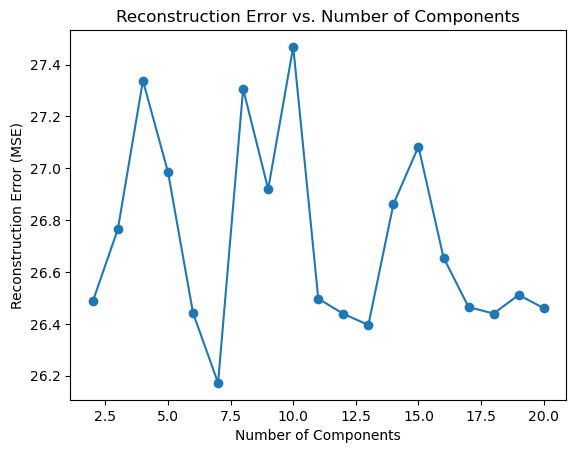

In [12]:
# Extract values for plotting
components = [n for n, _ in errors]
mse_values = [mse for _, mse in errors]

# Plot the reconstruction error
plt.plot(components, mse_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components')
plt.show()

In [13]:
# Apply final the best number of component for UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=least_error_component, random_state=123)
X_umap = umap_reducer.fit_transform(X_pca)
X_umap

array([[1.5857029, 4.2022576, 8.334184 , ..., 3.35107  , 5.515199 ,
        6.3131266],
       [1.6797055, 4.1183715, 8.420249 , ..., 3.3914518, 5.644021 ,
        6.2884197],
       [1.6493722, 4.0730634, 8.457553 , ..., 3.3712704, 5.634795 ,
        6.2606373],
       ...,
       [8.628194 , 9.595672 , 4.8236423, ..., 4.0012445, 2.9891486,
        6.1237717],
       [8.665291 , 9.482118 , 4.8439975, ..., 4.01278  , 3.0496004,
        6.1042633],
       [8.682006 , 9.5502615, 4.82096  , ..., 4.0167007, 3.003234 ,
        6.098212 ]], dtype=float32)

In [14]:
# Initialize Agglomerative Clustering
expected_cluster = 20
agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric='euclidean', linkage='ward')
# Fit the model and predict cluster labels
cluster_labels = agg_cluster.fit_predict(X_umap)
agg_cluster_labels = cluster_labels

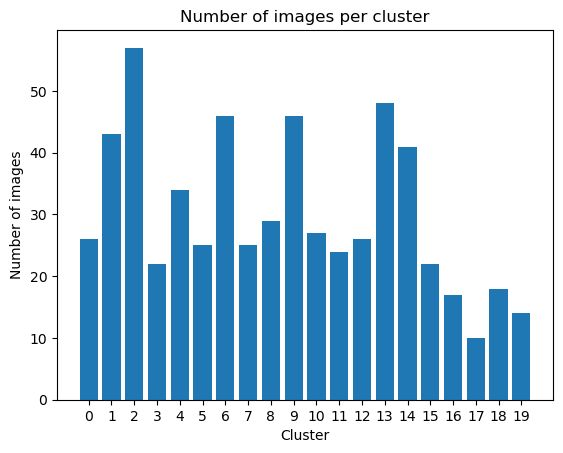

In [15]:
plt.bar(range(expected_cluster), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(expected_cluster))
plt.show()

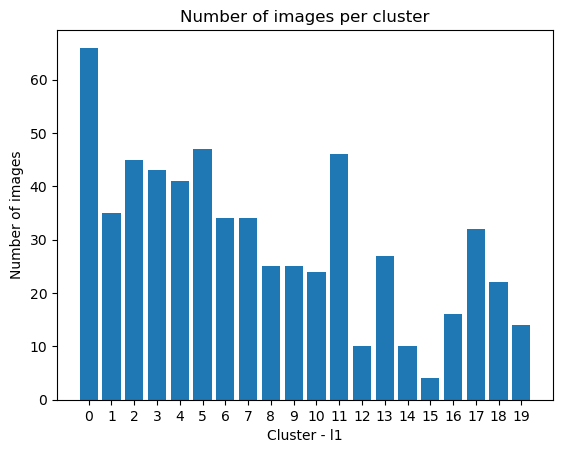

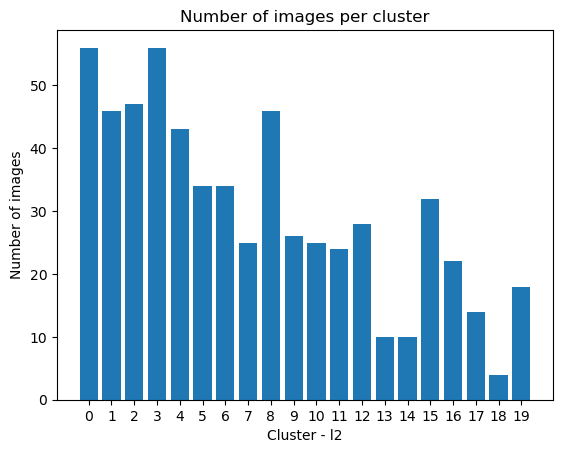

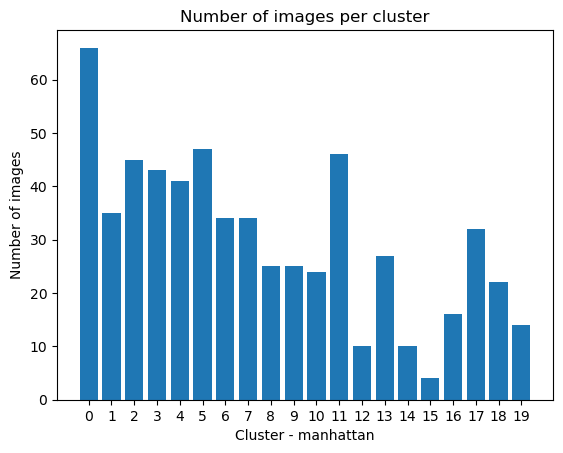

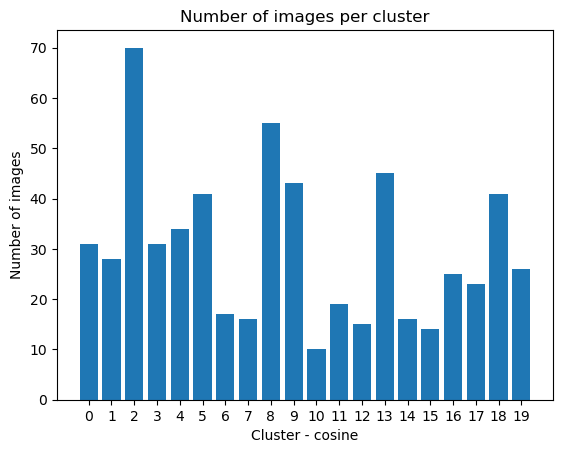

In [16]:
metrics = ['l1', 'l2', 'manhattan', 'cosine']
expected_cluster = 20

for met in metrics:
    agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric=met, linkage='average')
    
    # Fit the model and predict cluster labels
    cluster_labels = agg_cluster.fit_predict(X_umap)

    plt.bar(range(expected_cluster), np.bincount(cluster_labels))
    plt.xlabel(f'Cluster - {met}')
    plt.ylabel('Number of images')
    plt.title('Number of images per cluster')
    plt.xticks(range(expected_cluster))
    plt.show() 

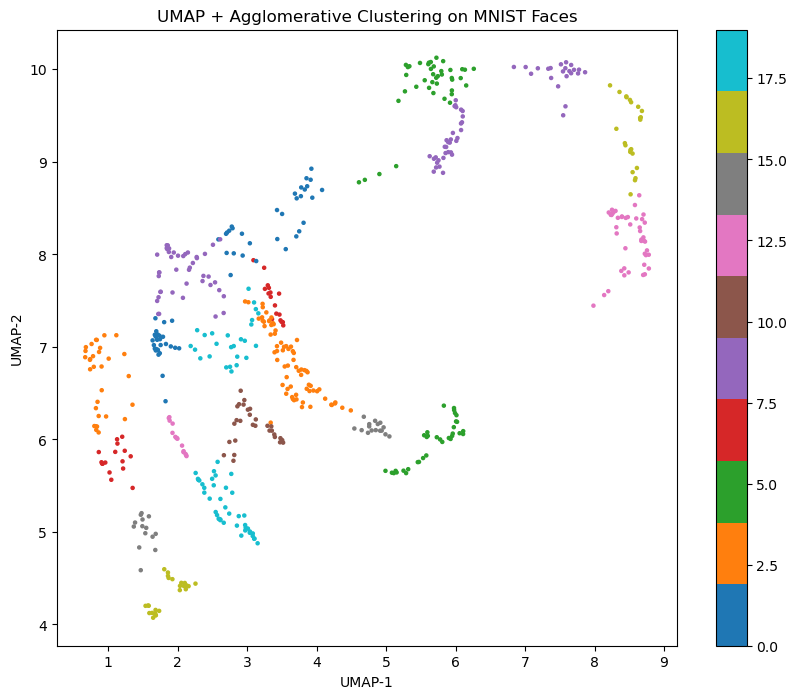

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("UMAP + Agglomerative Clustering on MNIST Faces")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [18]:
# Measure the quality of clustering (higher is better for silhouette score)
silhouette = silhouette_score(X_umap, cluster_labels)
print(f"Silhouette Score: {silhouette:.2f}")

Silhouette Score: 0.42


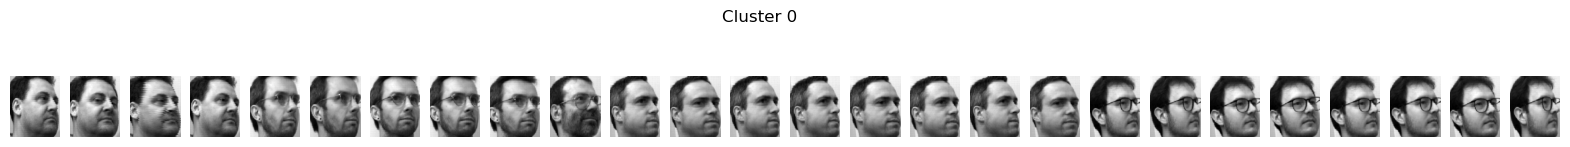

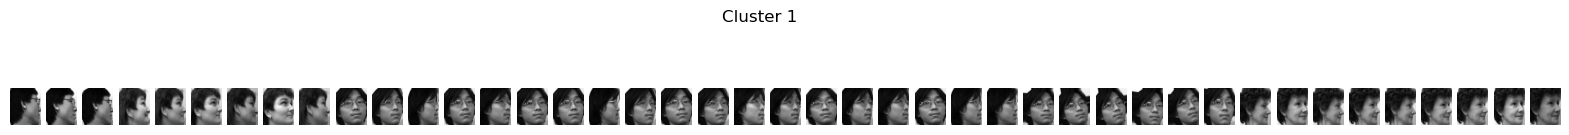

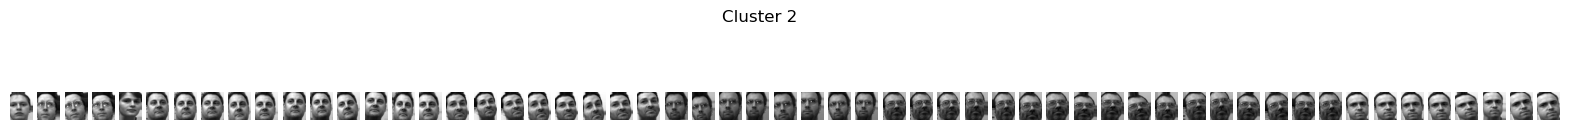

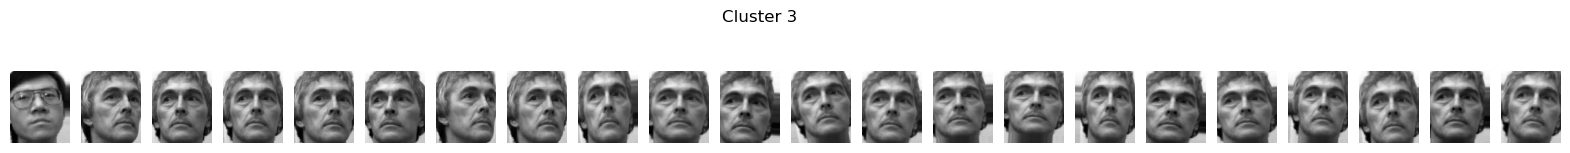

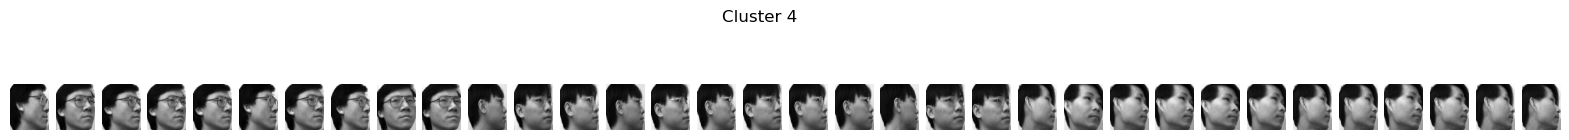

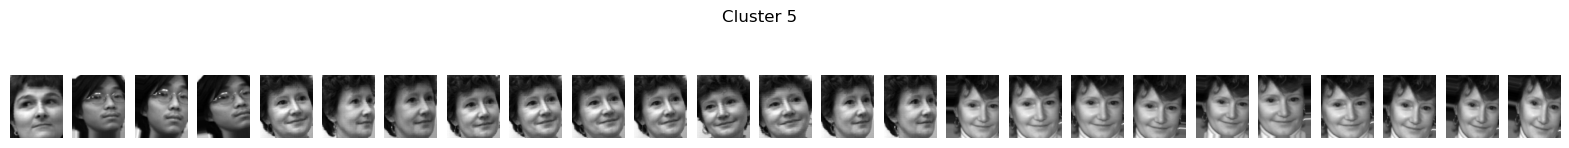

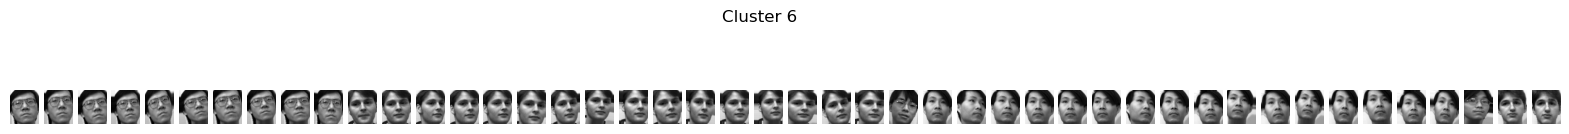

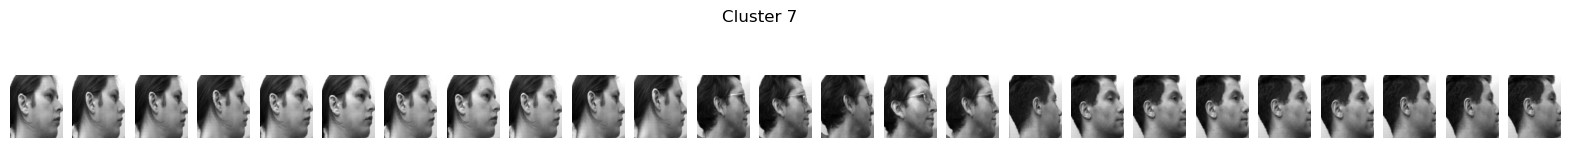

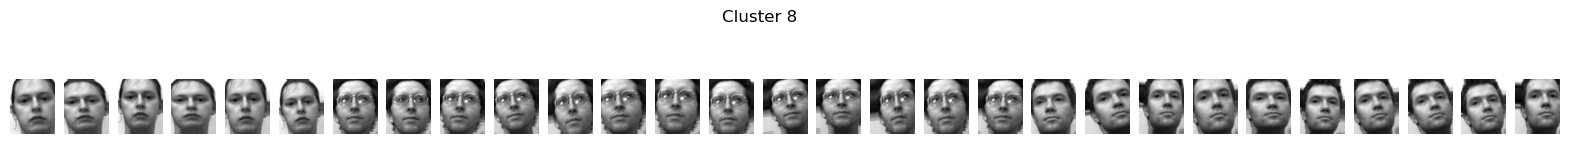

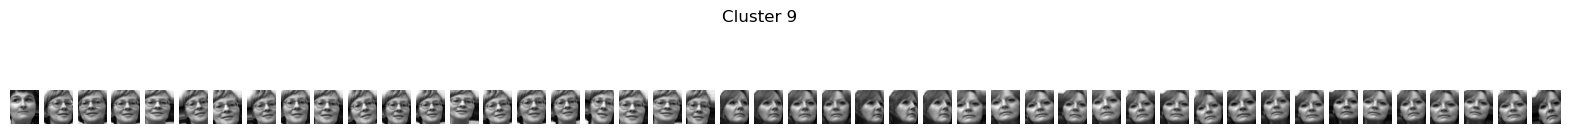

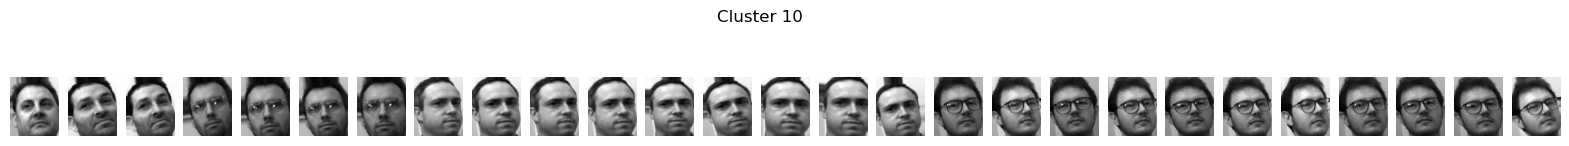

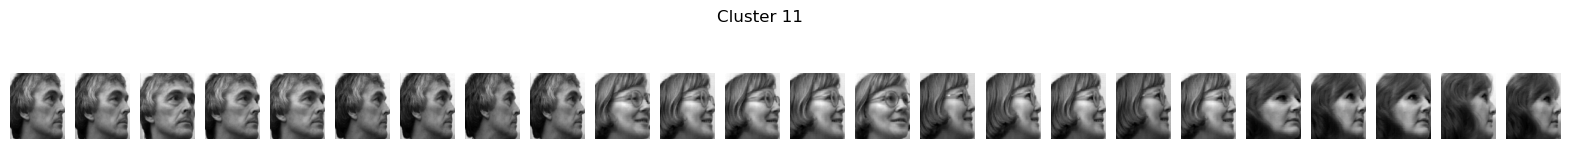

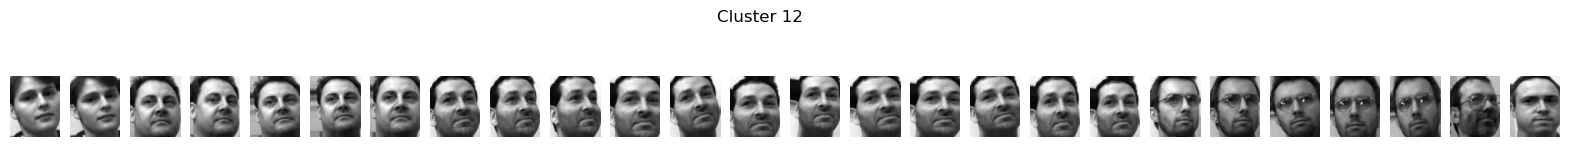

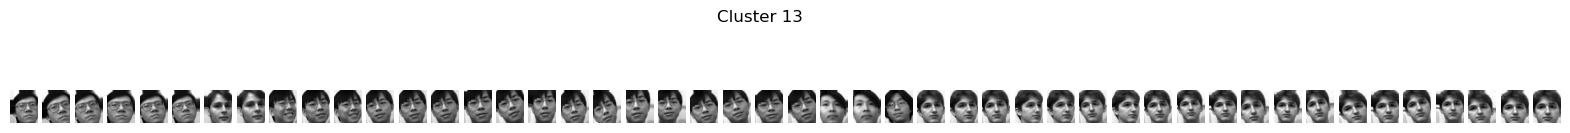

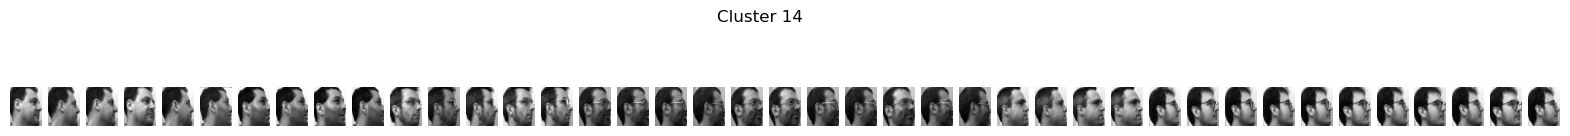

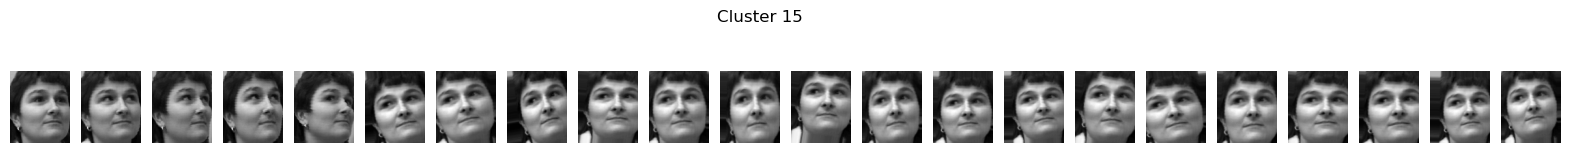

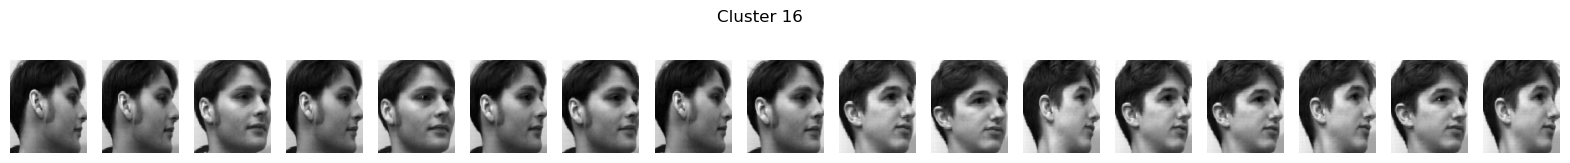

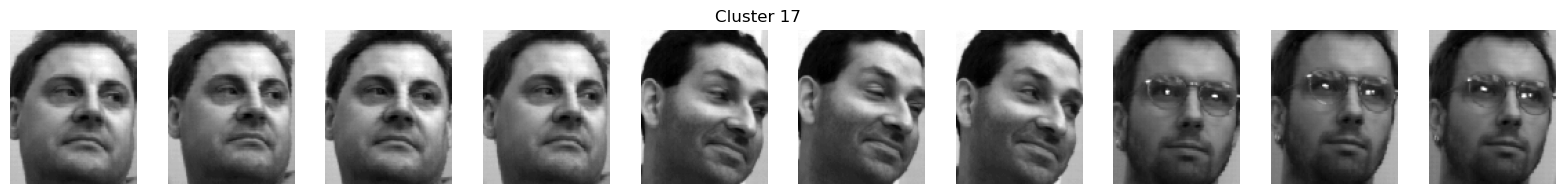

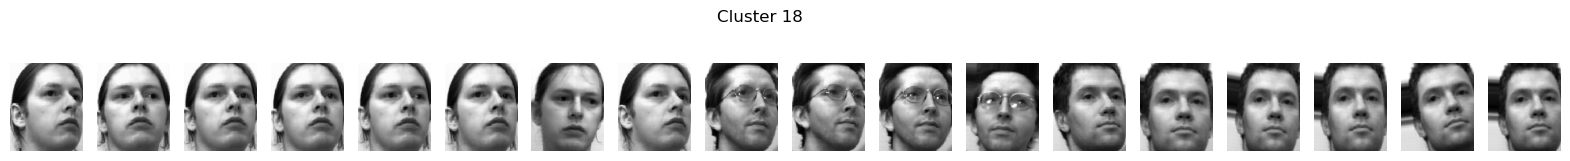

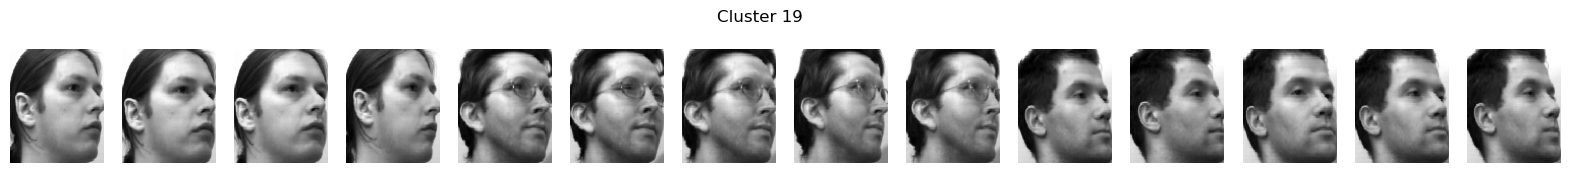

In [19]:
def plot_result(cluster_labels, cluster_num):
    for cluster_id in range(cluster_num+1):
        # Get the indices of images in the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Determine the number of images to plot
        num_images = len(cluster_indices)
        
        if num_images > 0:
            fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
            
            # Handle the case where there is only one image
            if num_images == 1:
                axes = [axes]  # Convert single axis to a list for consistency
            
            for i in range(num_images):
                # Get the image index
                image_index = cluster_indices[i]
                
                # Get the image data
                image_data = X_train[image_index]
                
                # Reshape the image data
                image_data = image_data.reshape(112, 92)
                
                # Plot the image
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
            plt.suptitle(f"Cluster {cluster_id}")
            plt.show()
plot_result(agg_cluster_labels, expected_cluster)

Average linkage and euclidean metric: 

Number of clusters: 20
Silhouette Score: 0.4772084653377533


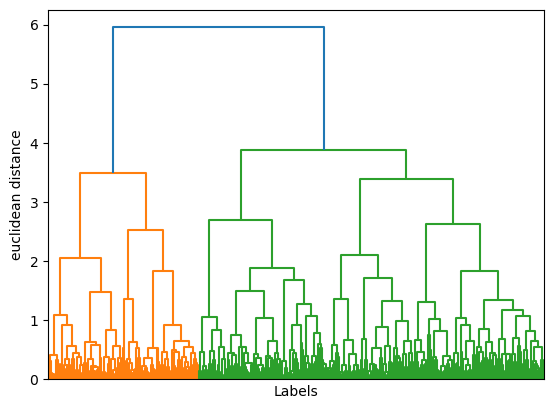

Average linkage and minkowski metric: 

Number of clusters: 20
Silhouette Score: 0.48726061180373376


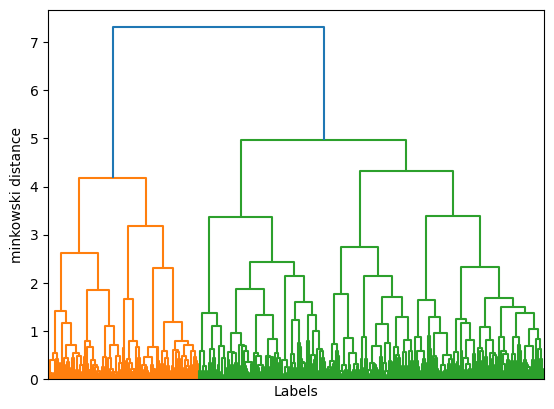

Average linkage and cosine metric: 

Number of clusters: 20
Silhouette Score: 0.602756679058075


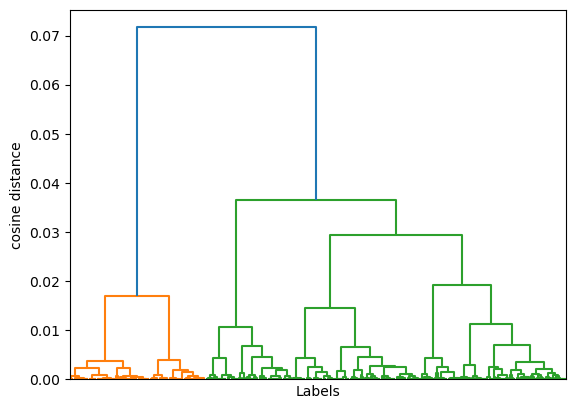

Average linkage and cityblock metric: 

Number of clusters: 20
Silhouette Score: 0.4628645380328936


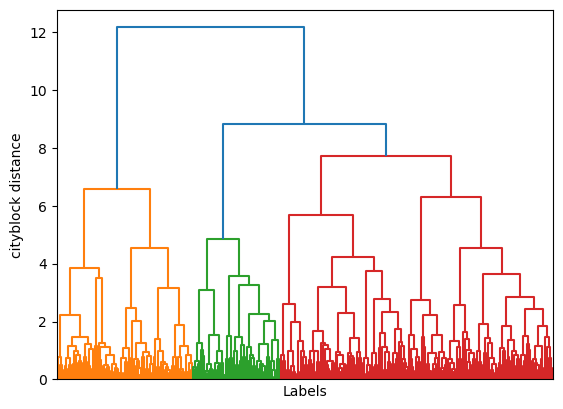

In [20]:
metrics_list = ['euclidean', 'minkowski', 'cosine', 'cityblock']       
                
results = {}
square_distances_matrix = []
clusters_res = []

for m in metrics_list:
    print(f'Average linkage and {m} metric: \n')
    
    if m == 'minkowski':
        Y = pdist(X_umap, metric=m, p=1.5)
    else:
        Y = pdist(X_umap, metric=m)
        
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, 20, criterion='maxclust')
    dendrogram(Z, no_labels= True)
    # Check the number of clusters
    num_clusters = len(set(clusters))
    clusters_res.append(clusters)
    print(f'Number of clusters: {num_clusters}')
    silhouette = silhouette_score(X_umap, clusters, metric=m)
    print(f'Silhouette Score: {silhouette}')
    plt.xlabel("Labels")
    plt.ylabel(f'{m} distance')
    plt.show()

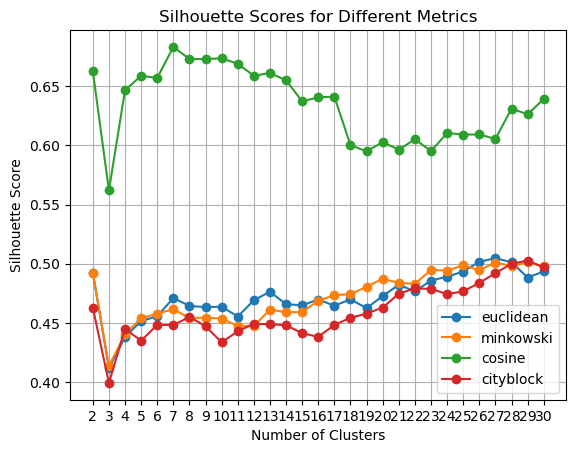

In [21]:
max_clusters = 30  # Maximum number of clusters to test
for metric in metrics_list:
    silhouette_scores = []
    
    # Iterate through the possible number of clusters
    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        # Compute pairwise distances
        if metric == 'minkowski':
            Y = pdist(X_umap, metric=metric, p=1.5)
        else:
            Y = pdist(X_umap, metric=metric)
        
        if metric in ['euclidean']:
            Z = linkage(Y, method='ward')
        else:
            Z = linkage(Y, method='average')

        # Create flat clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Check the number of clusters formed
        num_clusters_formed = len(set(clusters))
        
        # Ensure that the number of clusters is valid
        if num_clusters_formed > 1:
            # Calculate silhouette score
            silhouette = silhouette_score(X_umap, clusters, metric=metric)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(-1)  # Append a negative score or None if not valid

    # Store results for the current metric
    results[metric] = silhouette_scores

    # Plotting
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)

# Plotting
plt.title("Silhouette Scores for Different Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, max_clusters + 1))
plt.legend()
plt.grid()
plt.show()

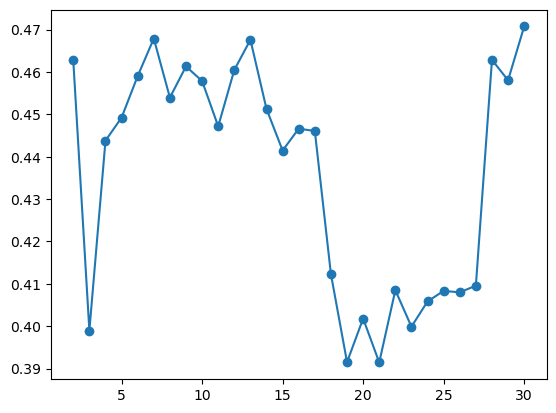

In [22]:
silhouette_scores = []
best_cluster_num = 1
best_score = 0

for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
    Y = pdist(X_umap, metric='cosine')
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    num_clusters_formed = len(set(clusters))
    if num_clusters_formed > 1:
        silhouette = silhouette_score(X_umap, clusters, metric=metric)
        silhouette_scores.append(silhouette)
        if silhouette > best_score:
            best_score = silhouette
            best_cluster_num = num_clusters_formed
    else:
        silhouette_scores.append(-1)  # Append a negative score or None if not valid
# Plotting
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)
plt.show()

In [23]:
print(f'The best cluster number: {best_cluster_num} with score {best_score}')

The best cluster number: 30 with score 0.47073813371938705


In [33]:
# Set a cutoff distance
cutoff_distance = best_cluster_num 
# Get cluster labels
cluster_labels = fcluster(Z , cutoff_distance, criterion='maxclust')
print("Cluster labels for each image:", Counter(cluster_labels))

Cluster labels for each image: Counter({6: 45, 4: 37, 2: 33, 20: 32, 12: 30, 23: 26, 15: 26, 28: 26, 8: 25, 30: 25, 5: 23, 1: 22, 18: 20, 16: 19, 27: 19, 25: 18, 19: 18, 29: 18, 17: 17, 21: 16, 13: 16, 10: 15, 7: 14, 24: 13, 11: 11, 9: 10, 26: 9, 14: 8, 22: 5, 3: 4})


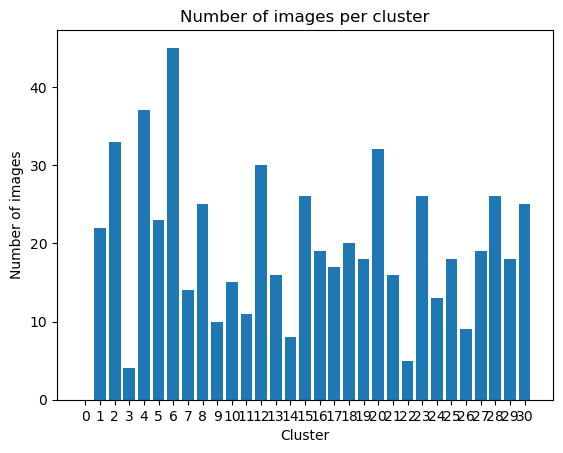

In [34]:
plt.bar(range(cutoff_distance+1), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(cutoff_distance+1))
plt.show()

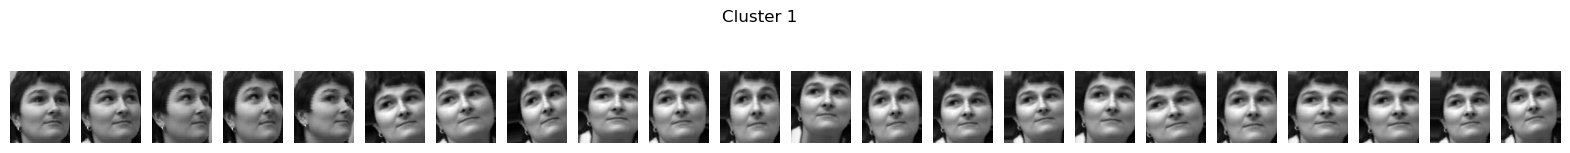

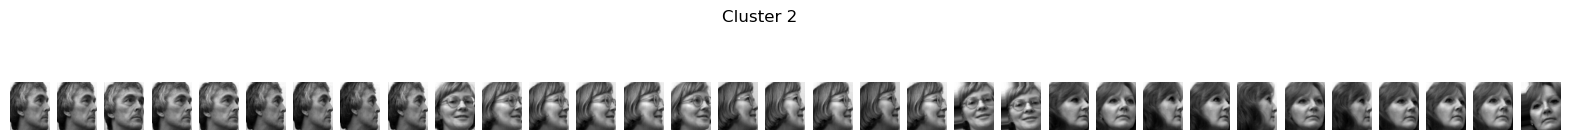

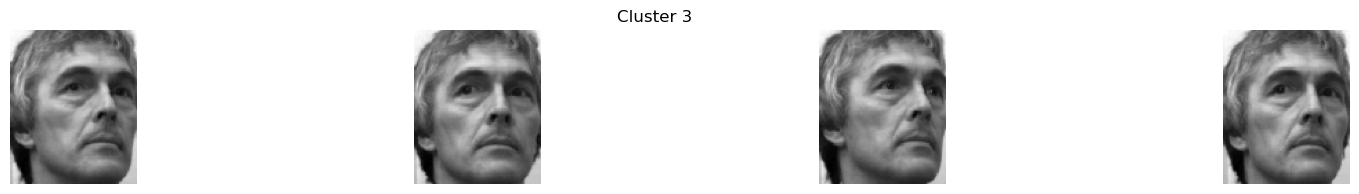

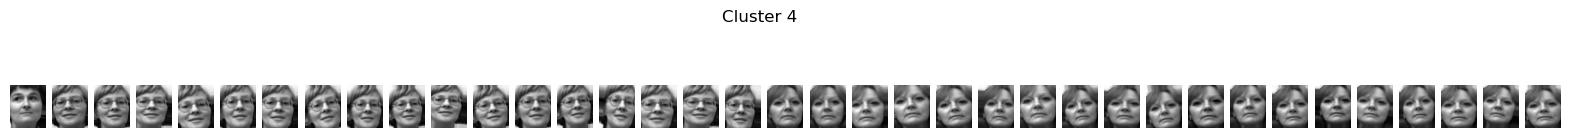

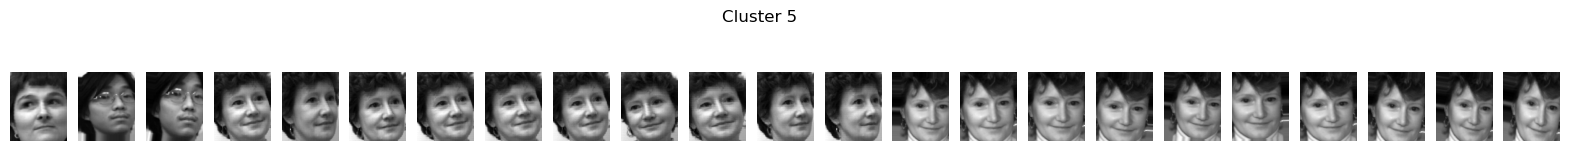

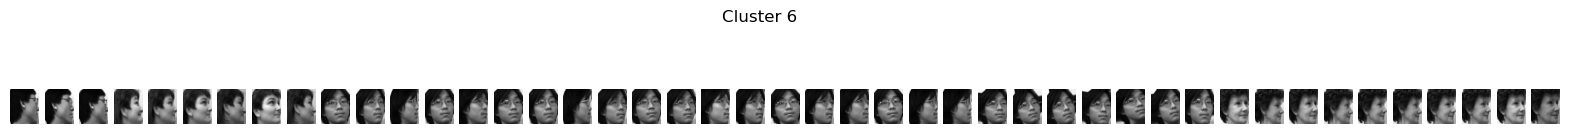

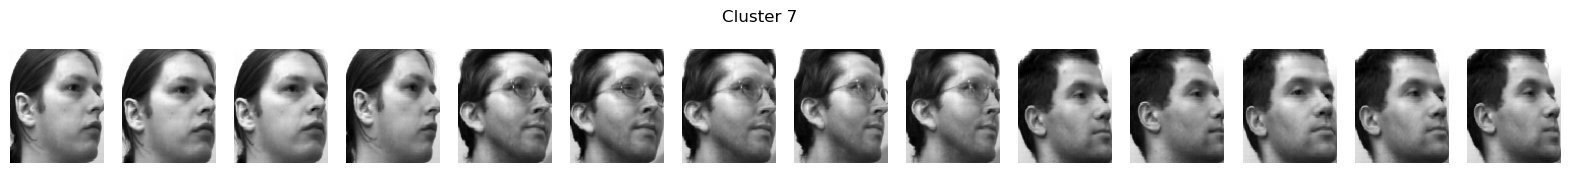

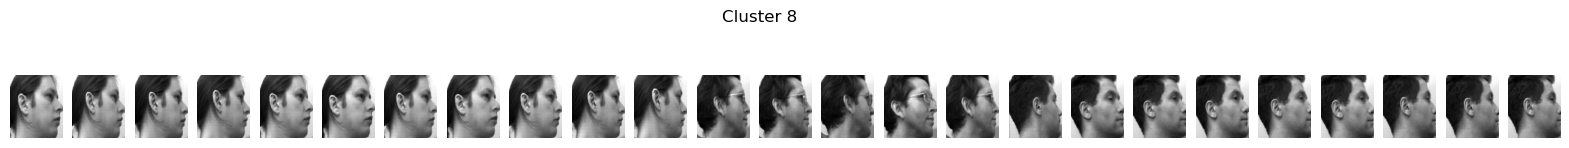

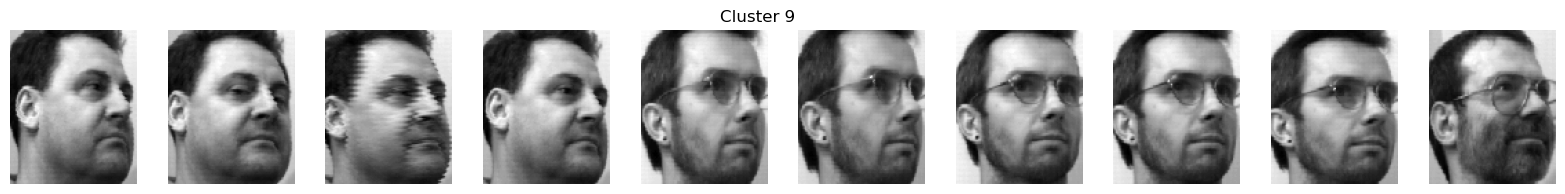

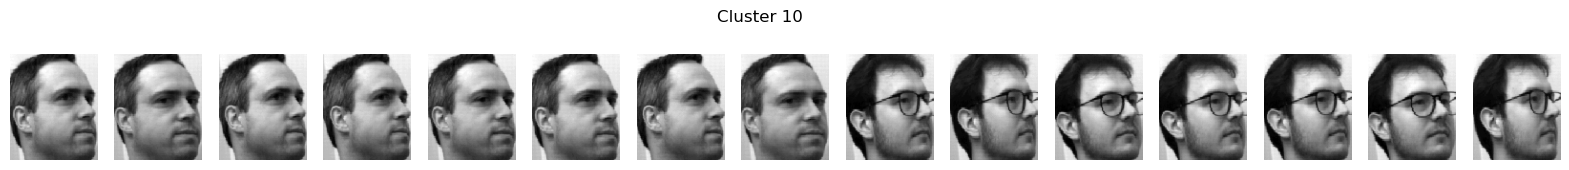

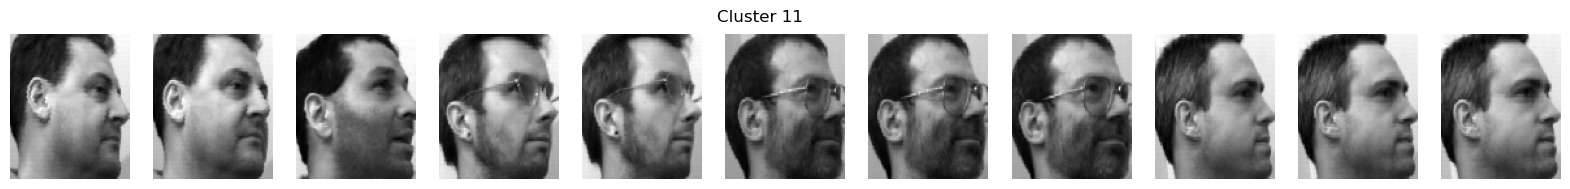

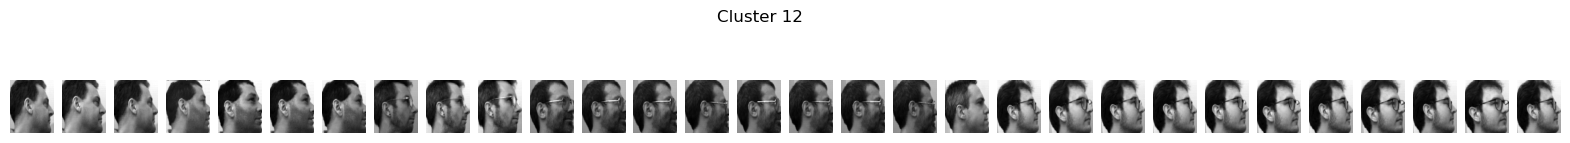

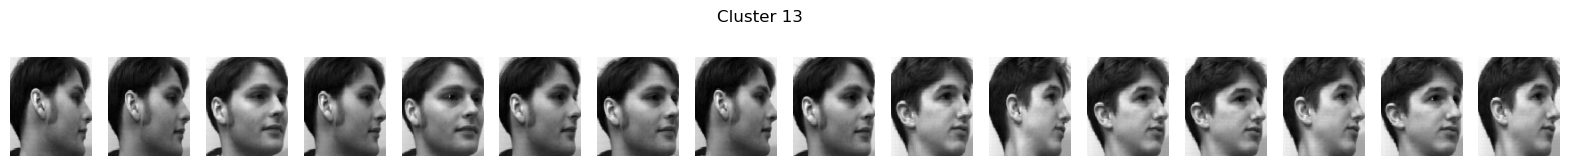

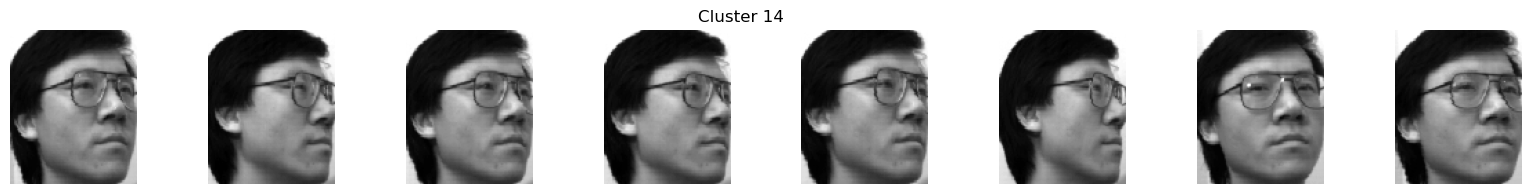

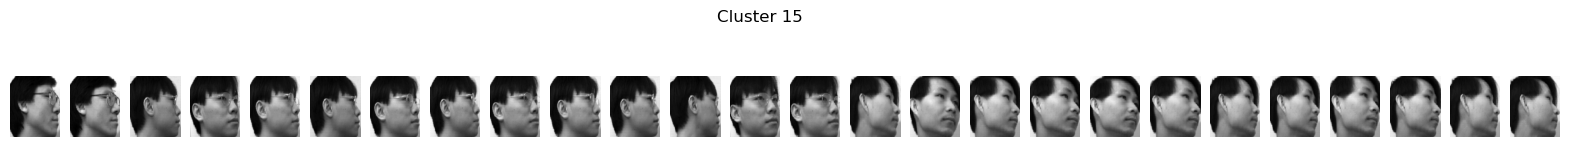

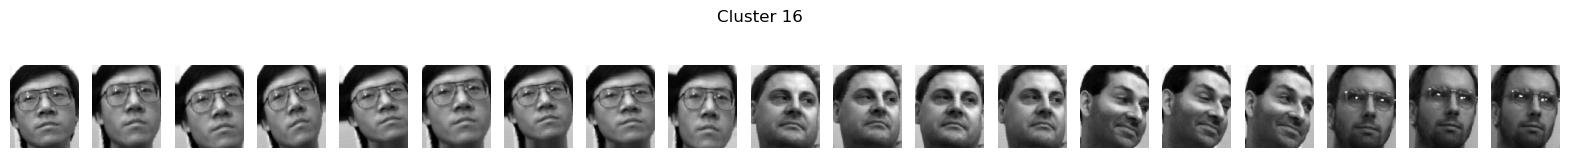

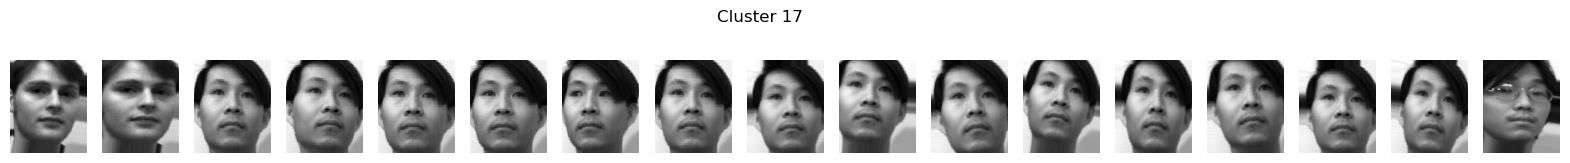

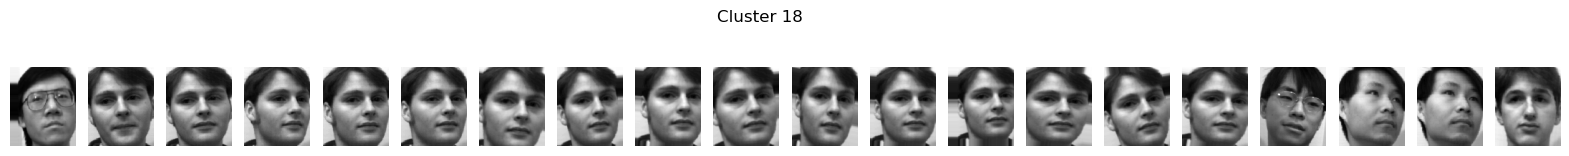

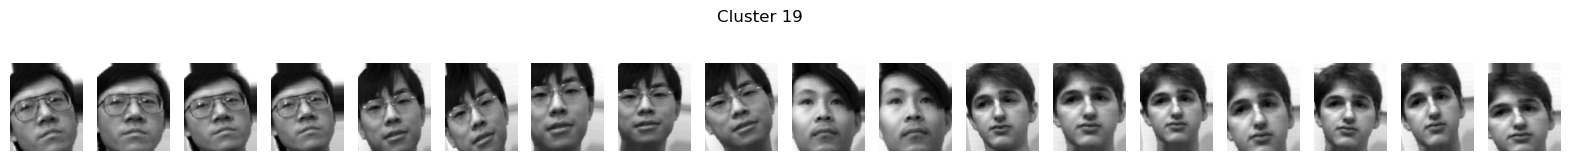

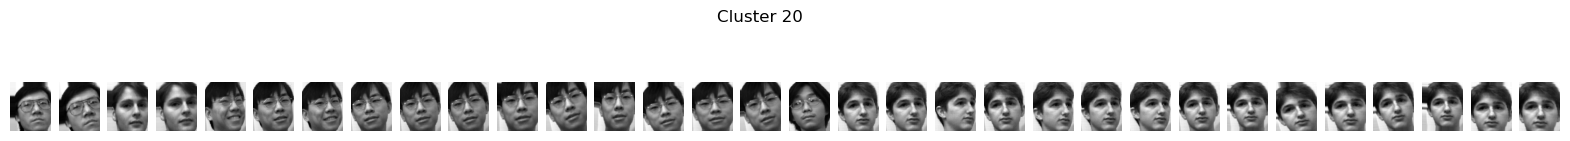

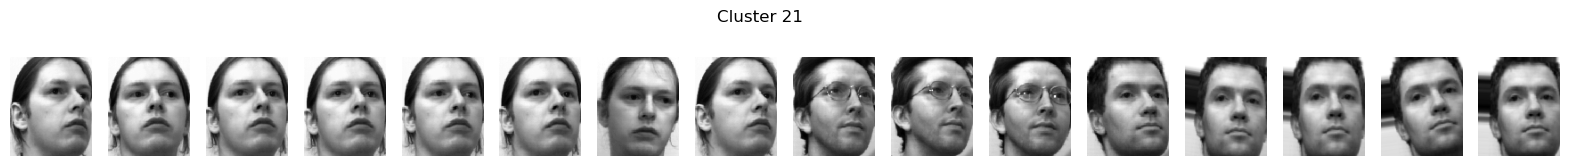

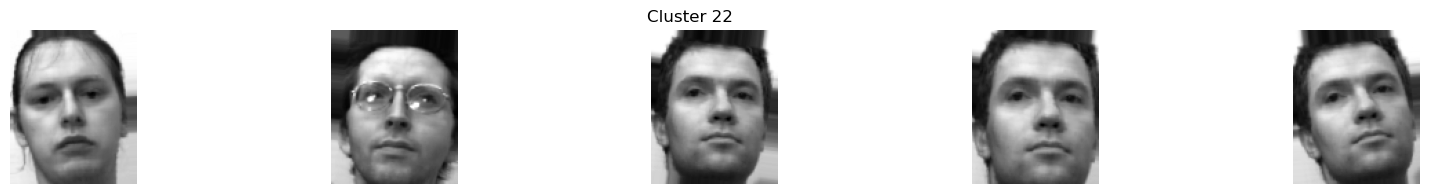

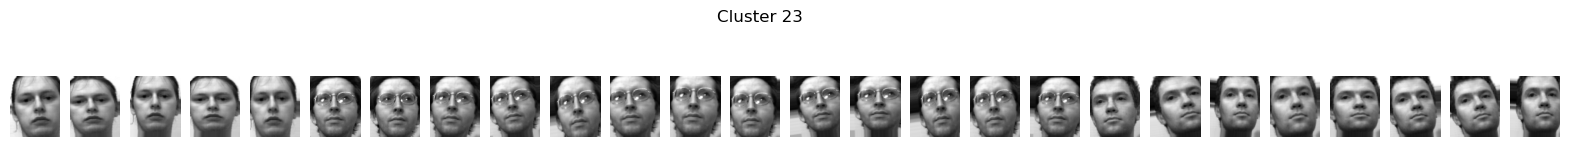

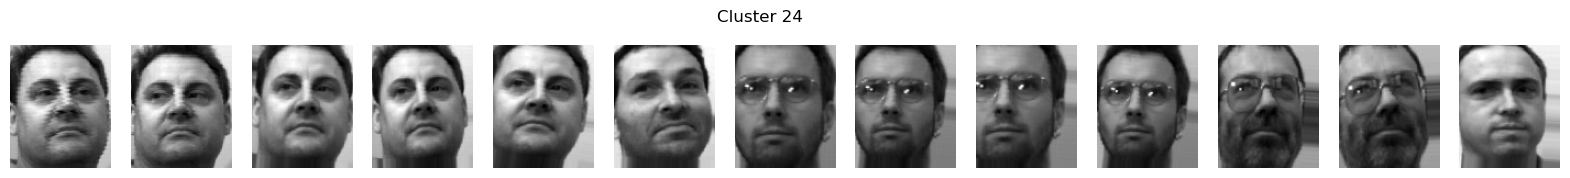

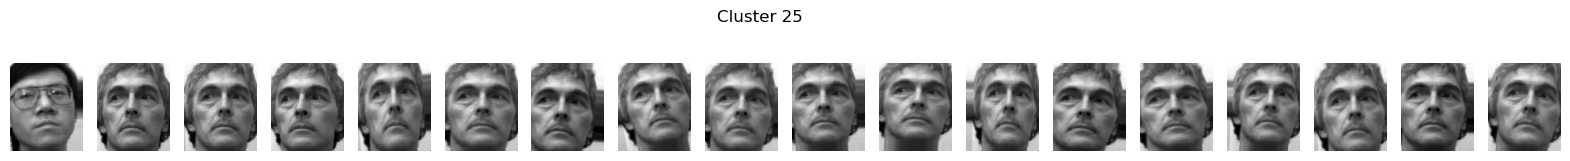

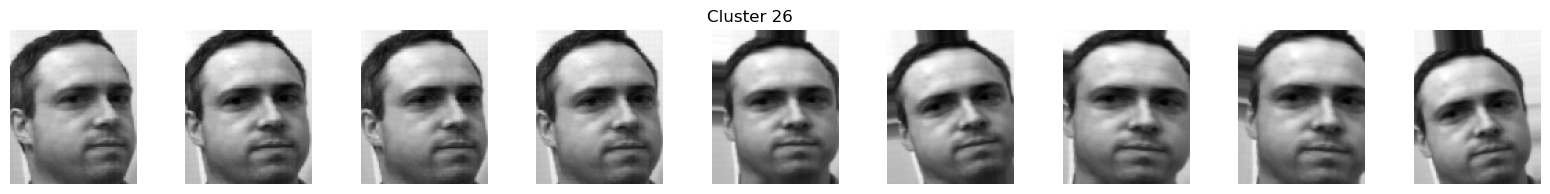

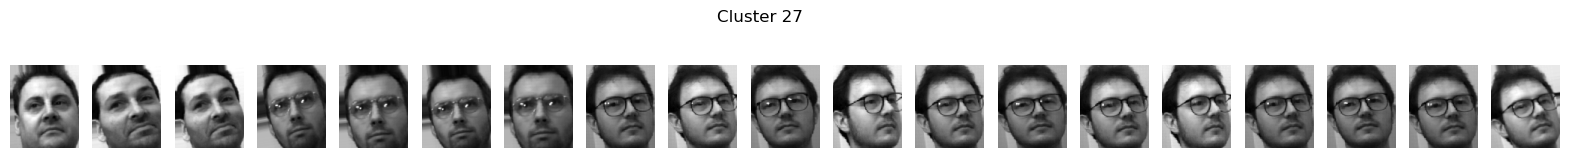

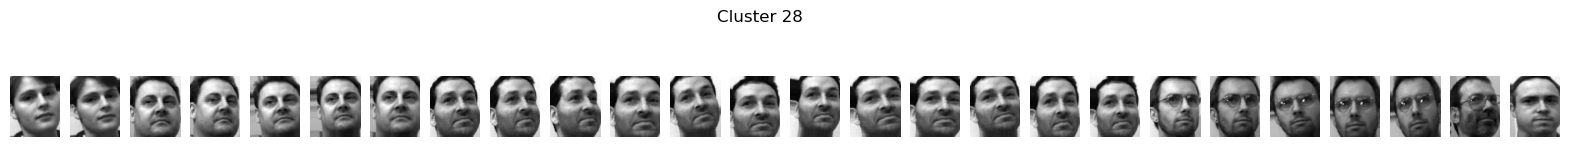

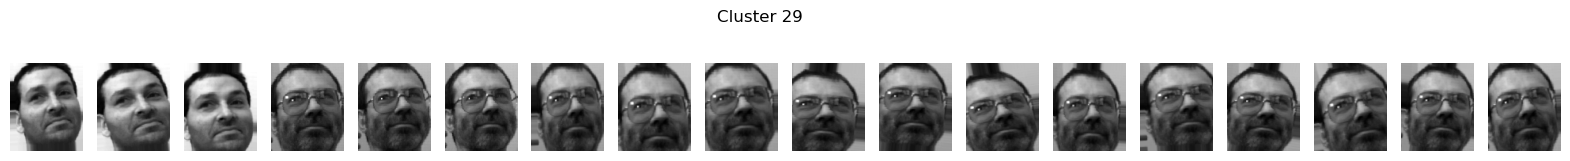

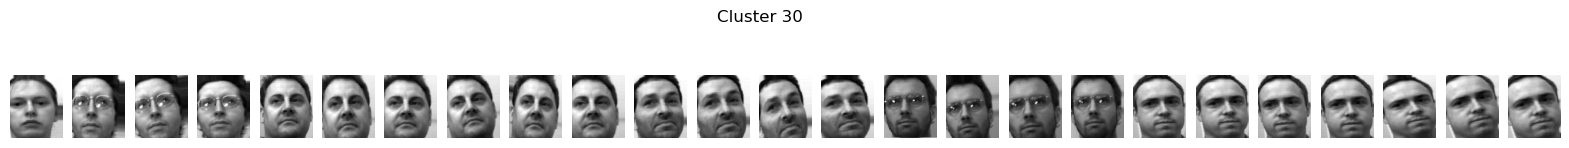

In [35]:
plot_result(cluster_labels, cutoff_distance)

In [36]:
# Plot the distribution of each cluster
original_data = pd.read_csv("data/umist_with_original_face_id.csv")

In [37]:
original_data['cluster_id'] = cluster_labels

In [38]:
original_labels = original_data['label']
clustered_labels = original_data['cluster_id']

In [39]:
unique_labels = np.unique(original_labels)
unique_clustered_labels = np.unique(clustered_labels)

original_labels = original_labels.to_numpy()
clustered_labels = clustered_labels.to_numpy()

In [40]:
def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 10 else ''

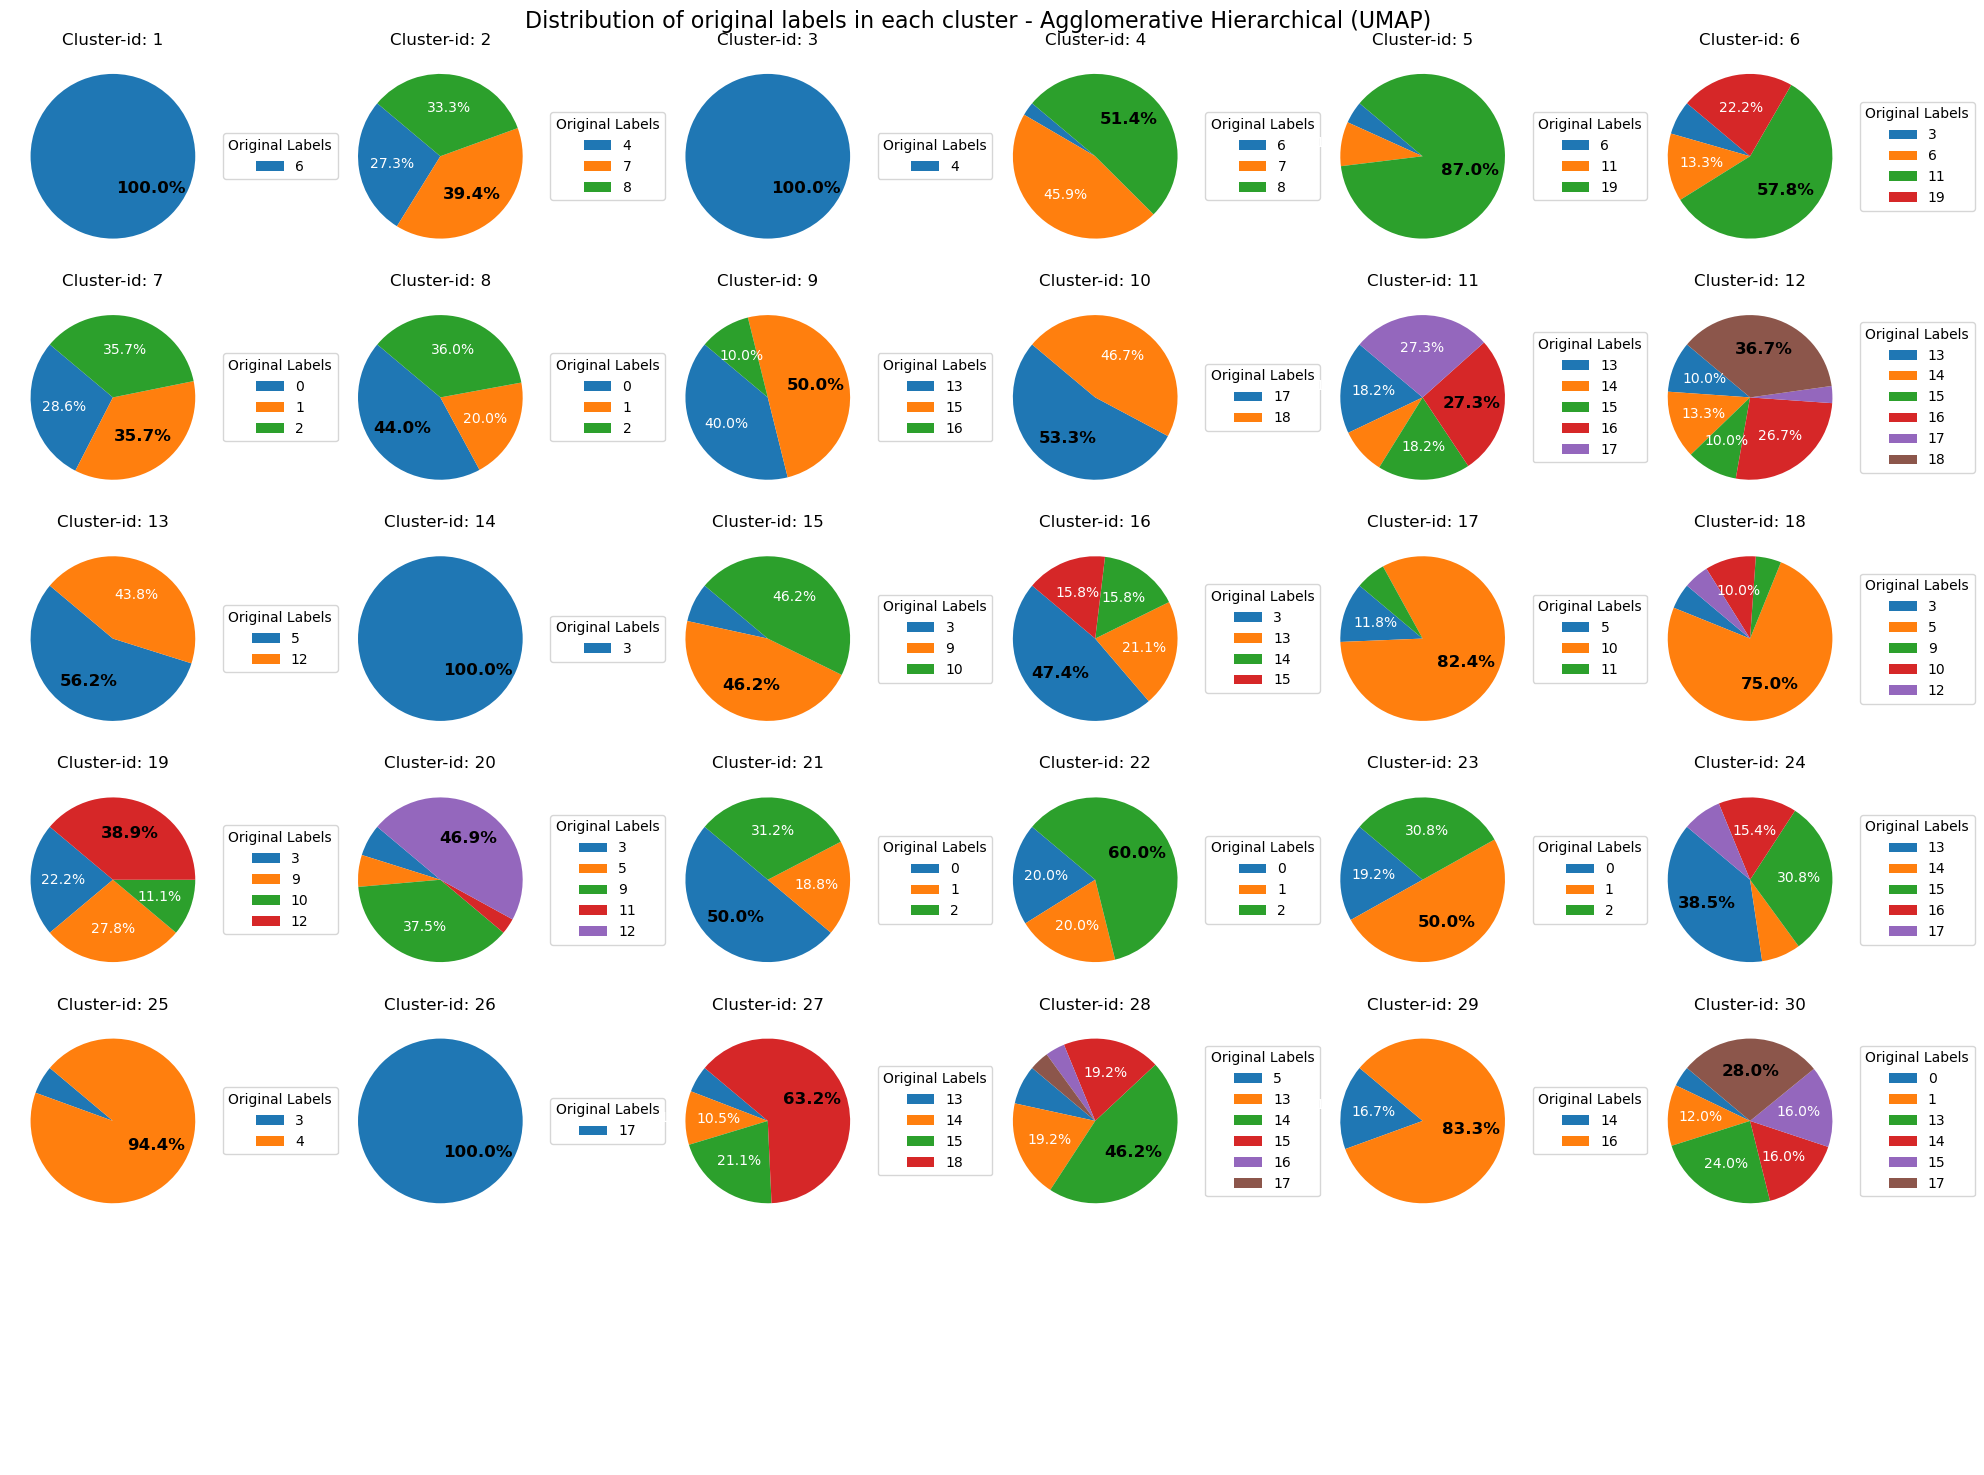

In [41]:
import math

df = pd.DataFrame({'Original Labels': original_labels, 'Clustered Labels': clustered_labels})

# Calculate grid dimensions
num_clusters = len(unique_clustered_labels)
grid_size = math.ceil(math.sqrt(num_clusters))  # Determine size of the grid (square root for square layout)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 15), subplot_kw=dict(aspect="equal"))
axes = axes.flatten()

for i, cluster in enumerate(unique_clustered_labels):
    cluster_data = df[df['Clustered Labels'] == cluster]
    cluster_original_labels = cluster_data['Original Labels']
    
    cluster_original_labels_count = Counter(cluster_original_labels)
    labels = list(cluster_original_labels_count.keys())
    counts = list(cluster_original_labels_count.values())
    
    wedges, texts, autotexts = axes[i].pie(
        counts,
        labels=labels,
        autopct=lambda pct: autopct_format(pct),
        textprops=dict(color="w"),
        startangle=140
    )
    
    axes[i].legend(wedges, labels, title='Original Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Highlight the largest percentage
    largest_pct_idx = np.argmax(counts)
    autotexts[largest_pct_idx].set_color('black')
    autotexts[largest_pct_idx].set_fontsize(12)
    autotexts[largest_pct_idx].set_fontweight('bold')
        
    axes[i].set_title(f'Cluster-id: {cluster}')
        
# Turn off unused subplots
for j in range(num_clusters, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of original labels in each cluster - Agglomerative Hierarchical (UMAP)', fontsize=16)
plt.tight_layout()
plt.show()
